In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [79]:
### Retrieve input paramters
input_file_path = r"Cc_Ck_Input_2.txt"

token = '$$ Material'
Material_prop = []
current_material_dict = {}

with open(input_file_path, "r") as file:
    line = file.readline().strip()
    while line:
        if line.startswith(token) and current_material_dict:
            # if line starts with token and the dictionary is not
            Material_prop.append(current_material_dict) # Add dictionary values to array
            current_material_dict = {} # Clear dictionary
        # if not retrive next...
        key = line[2:].strip() # Material property name
        value = float(file.readline().strip()) # Material property value
        current_material_dict[key] = value # Store Material property name and value
        line = file.readline().strip() # Read next file line
Material_prop.append(current_material_dict) # append the last material

[{'Gamma_w (kN/m^3)': 9.81, 'G_s': 2.65}, {'Material_ID': 1.0, 'PRECONSOLIDATION_STRESS': 1.0, 'Cc': 0.9, 'Cr/Cc': 0.21, 'e0': 3.0, 'ef': 0.5, 'Input_Num_Points': 68.0, 'Cv (cm^2/s)': 0.001}, {'Material_ID': 2.0, 'PRECONSOLIDATION_STRESS': 10.0, 'Cc': 10.0, 'Cr/Cc': 10.0, 'e0': 10.0, 'ef': 10.0, 'Input_Num_Points': 10.0, 'Cv (cm^2/s)': 10.0}]


In [68]:
### Cc Inputs
Pre_ConsolStress = values["PRECONSOLIDATION_STRESS"]
Cc = values["Cc"] # Virgin compression slope
Cr_ratio = values["Cr/Cc"] # Ratio of C_r to C_c
e0 = values["e0"] # Initial void ratio
ef = values["ef"] # Final value of void ratio
input_num_points = int(values["Input_Num_Points"]) # Number of spaces avalialable for inputs in PSDDF

### Ck Inputs
Cv = values["Cv (cm^2/s)"] * 1e-4
gamma_w = values["Gamma_w (kN/m^3)"]


KeyError: 'PRECONSOLIDATION_STRESS'

In [ ]:
num_points = input_num_points + 1 # Add a data point so that when the Cr and Cc arrays are later appened the length is correct

In [ ]:
# Calculate the maximum eff_stres possible before e becomes negative
max_stress = 10**((e0-ef)/Cc + np.log10(Pre_ConsolStress) * (-Cr_ratio + 1))
print(max_stress)
# Percentage of the loading that is reloading (swell)
# (Used to calculate the number of points that should be used for the recompression)
Perc_reloading = (Pre_ConsolStress-1)/max_stress
print(Perc_reloading*100)

599.4842503189409
0.0


In [ ]:
# Number of points to generate
# num_points = 100 + 1

### Rework this!!! This will likely cause a bug 
# Number of recompression points
num_Cr_points = 0#int(num_points * Perc_reloading + 1)
if num_Cr_points < 4 and Pre_ConsolStress > 1:
    num_Cr_points = 10
print("Number of Cr points: {:.2f}".format(num_Cr_points))

# Number of virgin compression points
num_Cc_points = num_points-num_Cr_points
print("Number of Cc points: {:.2f}".format(num_Cc_points))

Number of Cr points: 0.00
Number of Cc points: 69.00


In [ ]:
### Define arrays of effective stress points

#### Virgin Compression initialization
Cc_eff_stress = np.linspace(Pre_ConsolStress, max_stress, num_Cc_points)

#### Recompression initializations 
Cr_eff_stress = np.linspace(1, Pre_ConsolStress,num_Cr_points)


In [ ]:
### Void ratio points for recompression
e_recomp = -1 * Cr_ratio * Cc * np.log10(Cr_eff_stress) + e0

### Void ratio for virgin compression

# Calculate intercept for Virgin compression line
if len(e_recomp) == 0:
    b = e0 + Cc * np.log10(Pre_ConsolStress)
else:
    b = e_recomp[-1] + Cc * np.log10(Pre_ConsolStress)

# Calulcate void ratios for virgin compression line
e_virgin = -Cc * np.log10(Cc_eff_stress) + b

### Append the two arrays
eff_stress = np.append(Cr_eff_stress, Cc_eff_stress[num_Cr_points:])
es = np.append(e_recomp, e_virgin[num_Cr_points:])

### Plot

In [ ]:
# Calc changes in void ratio
delta_es = es[num_Cr_points:-1] - es[num_Cr_points+1:]

# Calc volumetric strain
epsilon_V = np.cumsum(delta_es)/(1+e0)

# Calc delta volumetric strain
delta_epsilon_V = epsilon_V[:-1] - epsilon_V[1:]


NameError: name 'es' is not defined

In [ ]:
# Calc delta stress
delta_eff_stress = eff_stress[num_Cr_points:-1] - eff_stress[num_Cr_points+1:]

# Calc m_v
m_v = delta_epsilon_V/delta_eff_stress[1:] #[-/kN]

# Calc permeability
k = gamma_w * m_v * Cv * 100 #[cm/s]

#least-Squares fit of data
coefficients = np.polyfit(np.log10(k), es[num_Cr_points + 2:], deg = 1)

# Generate the best-fit line
best_fit_line = np.polyval(coefficients, np.log10(k))

# Print Best fit coefficients
print("## LS- Best fit coefficients ##")
print("Slope: {:.4f}\nIntercept: {:.4f}".format(coefficients[0], coefficients[1]))


## LS- Best fit coefficients ##
Slope: 0.8582
Intercept: 7.1958


[1.28470514e-05 1.17525610e-06 6.00535312e-07 4.00181422e-07
 2.98892992e-07 2.37954275e-07 1.97340014e-07 1.68375005e-07
 1.46697499e-07 1.29877329e-07 1.16454431e-07 1.05499274e-07
 9.63922718e-08 8.87047117e-08 8.21306142e-08 7.64458112e-08
 7.14823578e-08 6.71119742e-08 6.32350068e-08 5.97728791e-08
 5.66628078e-08 5.38540320e-08 5.13050722e-08 4.89817050e-08
 4.68554459e-08 4.49023972e-08 4.31023620e-08 4.14381557e-08
 3.98950659e-08 3.84604241e-08 3.71232629e-08 3.58740411e-08
 3.47044189e-08 3.36070752e-08 3.25755572e-08 3.16041552e-08
 3.06877991e-08 2.98219715e-08 2.90026345e-08 2.82261675e-08
 2.74893154e-08 2.67891432e-08 2.61229979e-08 2.54884753e-08
 2.48833919e-08 2.43057598e-08 2.37537657e-08 2.32257518e-08
 2.27202000e-08 2.22357169e-08 2.17710219e-08 2.13249355e-08
 2.08963700e-08 2.04843204e-08 2.00878569e-08 1.97061181e-08
 1.93383044e-08 1.89836730e-08 1.86415330e-08 1.83112405e-08
 1.79921952e-08 1.76838362e-08 1.73856395e-08 1.70971145e-08
 1.68178016e-08 1.654726

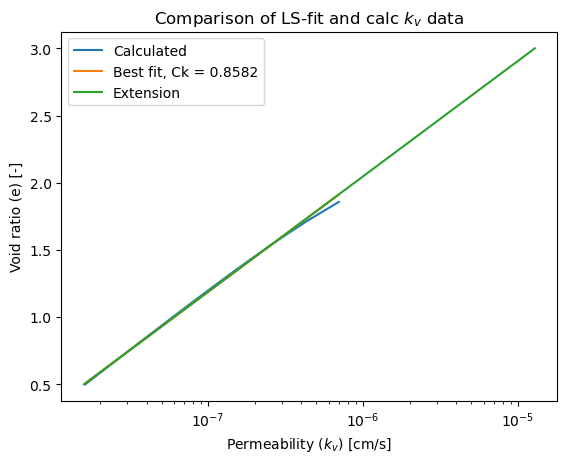

In [ ]:
# Extrapolate values for kv at initial void ratios

#least-Squares fit of data
e_coefficients = np.polyfit(es[num_Cr_points + 2:], np.log10(k), deg = 1)

# Generate the best-fit line
k_best_fit_line = 10**np.polyval(e_coefficients, es)

In [ ]:
### Generate Columns for PSDDF

### Need three columns void ratio | effective stress | permeability
# Before appending the columns together need to add data points to pearmeability data
file_path = "output.csv"
with open(file_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["e", "sigma", "k"])  # Write the header row
    writer.writerows(zip(["{:.3f}".format(value) for value in es],\
                         ["{:.2e}".format(value) for value in eff_stress],\
                         ["{:.2e}".format(value) for value in k_best_fit_line]))  # Write the data rows